In [1]:
import numpy as np
import matplotlib.pyplot as plt
import deepxde as dde 
from analytical import sound_hard_circle


dde.config.set_default_float('float64')
#dde.config.set_default_float('float32')


'''                        Problem parameters                               '''
k0 = 1       # wavenumber
# 5 is fine!
# 8 is more or less ok. ¿Add more points?
# Added more points, but not really ok with just 20.000 iterations + BFGS
# Change the learning rate? 
# Avec8 et 15 points, learning rate = 0.05, n'arrive pas a apprendre l'interieur...

wave_len = 2*np.pi / k0  # wavelength

dim_x = 2 * np.pi
n_wave = 20

# The mesh element size is h_elem
h_elem = wave_len / n_wave

nx = int(dim_x / h_elem)
print(h_elem, 'h_elem')
print( nx, 'nx')
print(nx **2, 'nx**2')

Using backend: tensorflow.compat.v1

2021-10-27 14:05:21.065934: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
non-resource variables are not supported in the long term

Set the default float type to float64
0.3141592653589793 h_elem
20 nx
400 nx**2


Compiling model...
Building feed-forward neural network...
'build' took 0.045246 s



/opt/conda/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/opt/conda/envs/DL/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2021-10-27 14:05:41.533757: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-10-27 14:05:41.867446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2021-10-27 14:

'compile' took 0.779734 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [7.36e-02, 1.07e+02]    [6.64e-02, 1.07e+02]    [1.09e+00]    


2021-10-27 14:05:42.284458: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000205000 Hz


1000      [1.49e-01, 1.03e+00]    [1.08e-01, 1.03e+00]    [2.61e-01]    
2000      [5.28e-02, 4.77e-03]    [3.18e-02, 4.77e-03]    [1.61e-01]    
3000      [1.32e-02, 1.06e-03]    [6.71e-03, 1.06e-03]    [9.91e-02]    
4000      [3.22e-03, 2.65e-04]    [2.05e-03, 2.65e-04]    [5.69e-02]    
5000      [1.43e-03, 1.13e-04]    [1.11e-03, 1.13e-04]    [4.51e-02]    
6000      [1.07e-03, 2.61e-04]    [9.43e-04, 2.61e-04]    [5.00e-02]    
7000      [7.87e-04, 6.74e-05]    [7.11e-04, 6.74e-05]    [4.50e-02]    
8000      [5.94e-04, 1.48e-03]    [5.41e-04, 1.48e-03]    [3.93e-02]    
9000      [5.05e-04, 2.83e-05]    [4.53e-04, 2.83e-05]    [3.52e-02]    
10000     [5.65e-04, 4.82e-04]    [5.55e-04, 4.82e-04]    [5.42e-02]    
11000     [4.15e-04, 1.47e-04]    [3.91e-04, 1.47e-04]    [4.41e-02]    
12000     [3.25e-04, 1.28e-03]    [2.91e-04, 1.28e-03]    [3.12e-02]    
13000     [2.78e-04, 1.78e-04]    [2.53e-04, 1.78e-04]    [3.79e-02]    
14000     [2.48e-04, 2.33e-04]    [2.28e-04, 2.33e-

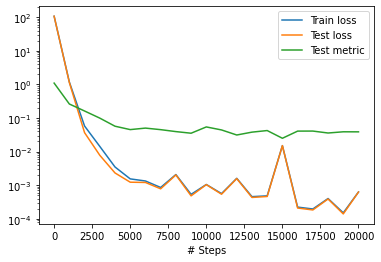

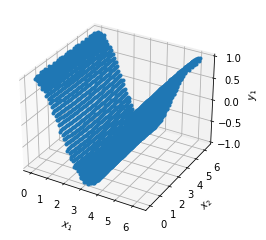

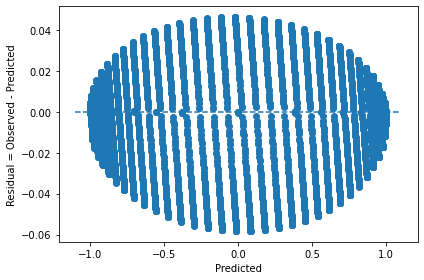

In [4]:
geom = dde.geometry.Rectangle([0, 0], [dim_x, dim_x])

def pde(x, y):
    
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    return -dy_xx - dy_yy - k0 ** 2 * y

def sol(x):
    return np.cos(k0 * x[:, 0:1])

def boundary(_, on_boundary):
    return on_boundary

bc = dde.DirichletBC(geom, sol, boundary)

weights = [1, 100]

data = dde.data.PDE(geom, pde, bc, num_domain= nx**2, num_boundary= 4 * nx, num_test= 10 * nx ** 2, solution = sol)
net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=0.001, loss_weights= weights, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#model.compile("L-BFGS")
#losshistory, train_state = model.train()

Relative error =  0.03298054841537359


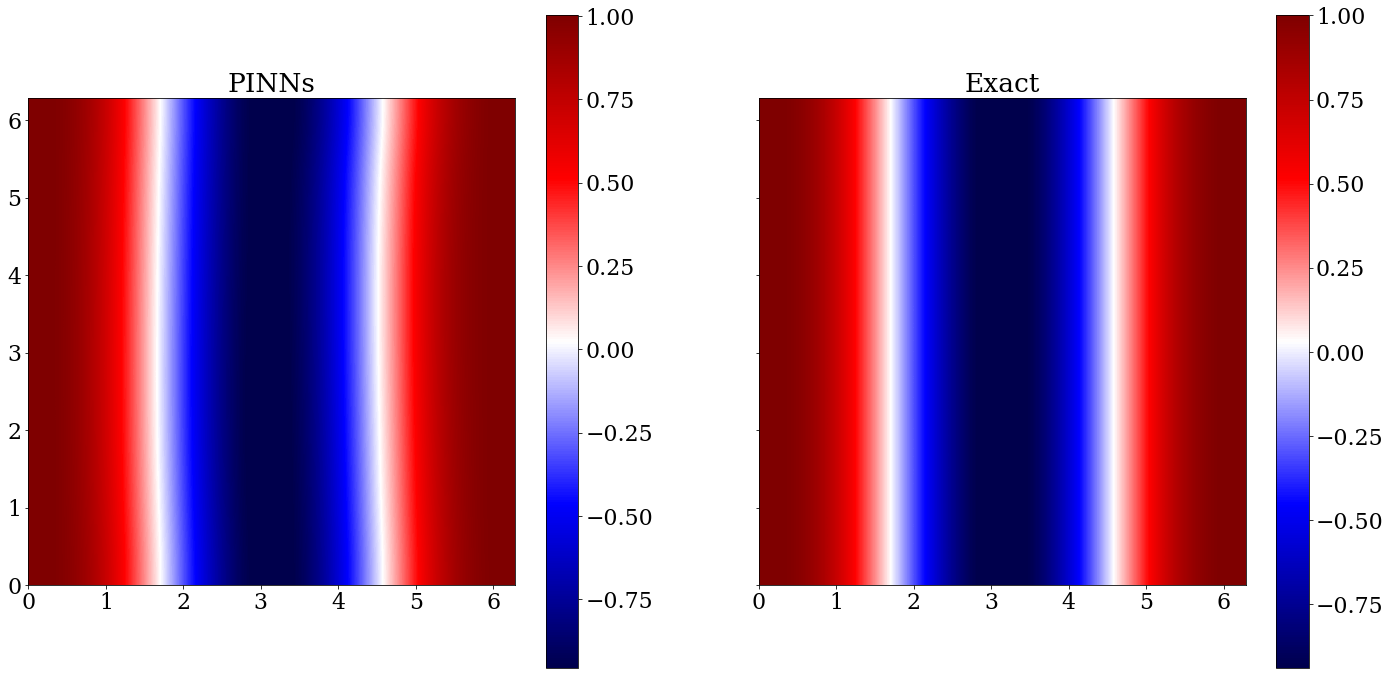

In [5]:

'''            Evaluate field over a specified grid of points              '''
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(dim_x/wave_len * 10))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [0, dim_x, 0, dim_x]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
#u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run

u_exact = sol(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(u_sca).T,
           extent=[0,dim_x,0,dim_x],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')

#ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(u_exact).T,
           extent=[0,dim_x,0,dim_x],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')


#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)
